# Notebook 3 - Implementacion de la Estrategia

Este notebook implementa **solo** la parte de se?ales y seleccion mensual de cartera usando retornos logaritmicos.
No ejecuta operaciones ni aplica comisiones: eso corresponde a `Notebook_4_Ejecucion_y_costes.ipynb`.

El objetivo operativo de este notebook es generar el fichero:
`data/processed/n3_selected_assets.csv`
con los **20 activos seleccionados por cada fecha de rebalanceo valida**.

## 1) Alcance y criterios tecnicos

La seleccion debe ser de **20 activos** por fecha, coherente con pesos del 5% por activo.

En este notebook se mantiene un enfoque fail-fast: si algun control critico falla, se detiene la ejecucion.
Asi evitamos exportar una seleccion que incumpla la especificacion.

In [1]:
# Librerias permitidas por el enunciado para N3.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo simple para visualizaciones de control del pipeline de se?ales.
sns.set_theme(style="whitegrid", context="talk")

# Entradas generadas en N1/N2.
N2_SIGNALS_INPUT_PATH = "data/processed/n2_signals_input.parquet"
N2_REBALANCE_CALENDAR_PATH = "data/processed/n2_rebalance_calendar.csv"
N1_RUNTIME_PARAMS_PATH = "data/processed/n1_runtime_params.csv"

# Salidas de N3.
OUT_N3_SELECTED_CSV = "data/processed/n3_selected_assets.csv"
OUT_N3_CHECKS_CSV = "data/processed/n3_strategy_checks.csv"

# Parametros estrategicos del enunciado.
TOP_N_ASSETS = 20
TARGET_WEIGHT = 0.05

# Esquema minimo necesario para construir las se?ales en N3.
REQUIRED_SIGNAL_COLUMNS = [
    "rebalance_date",
    "symbol",
    "close_t1",
    "close_t7",
    "close_t13",
    "eligible_for_signals",
    "has_required_lags",
]


def fail_if(condition: bool, message: str) -> None:
    """Aplica fail-fast para detener N3 ante errores criticos."""
    if condition:
        raise ValueError(message)


def record_check(
    rows: list,
    check: str,
    passed: bool,
    details: str,
    critical: bool = True,
) -> None:
    """Registra checks de calidad y corta ejecucion si falla un check critico."""
    rows.append(
        {
            "check": check,
            "passed": bool(passed),
            "critical": bool(critical),
            "details": details,
        }
    )
    fail_if(critical and not passed, f"[{check}] {details}")


def load_runtime_params(runtime_path: str) -> dict:
    """Carga parametros de N1 desde CSV key-value."""
    fail_if(
        not pd.io.common.file_exists(runtime_path),
        f"No existe runtime params: {runtime_path}",
    )
    runtime_df = pd.read_csv(runtime_path)
    fail_if(
        not {"parameter", "value"}.issubset(runtime_df.columns),
        "n1_runtime_params.csv no tiene columnas parameter/value.",
    )
    return dict(zip(runtime_df["parameter"], runtime_df["value"]))


# Registro centralizado de checks N3 para auditoria y readiness final.
n3_check_rows = []


## 2) Carga de artefactos N2 y validacion de esquema

Se cargan los artefactos preparados en N2 porque alli ya se resolvieron la regla point-in-time y el control anti look-ahead.
Antes de calcular se?ales se valida el esquema minimo para evitar errores silenciosos.

In [2]:
runtime_params = load_runtime_params(N1_RUNTIME_PARAMS_PATH)

fail_if(
    not pd.io.common.file_exists(N2_SIGNALS_INPUT_PATH),
    f"No existe input de se?ales N2: {N2_SIGNALS_INPUT_PATH}",
)
fail_if(
    not pd.io.common.file_exists(N2_REBALANCE_CALENDAR_PATH),
    f"No existe calendario N2: {N2_REBALANCE_CALENDAR_PATH}",
)

signals_input = pd.read_parquet(N2_SIGNALS_INPUT_PATH, engine="pyarrow")
rebalance_calendar = pd.read_csv(N2_REBALANCE_CALENDAR_PATH)

# Tipado robusto para asegurar orden y comparaciones deterministas.
signals_input["rebalance_date"] = pd.to_datetime(
    signals_input["rebalance_date"],
    errors="coerce",
)
signals_input["symbol"] = signals_input["symbol"].astype("string")

rebalance_calendar["rebalance_date"] = pd.to_datetime(
    rebalance_calendar["rebalance_date"],
    errors="coerce",
)

if rebalance_calendar["has_required_lags"].dtype != bool:
    rebalance_calendar["has_required_lags"] = (
        rebalance_calendar["has_required_lags"]
        .astype("string")
        .str.lower()
        .map({"true": True, "false": False})
    )

missing_columns = sorted(set(REQUIRED_SIGNAL_COLUMNS) - set(signals_input.columns))
record_check(
    n3_check_rows,
    "n2_signals_required_columns",
    len(missing_columns) == 0,
    f"missing_columns={missing_columns}",
)

invalid_rebalance_dates = int(signals_input["rebalance_date"].isna().sum())
record_check(
    n3_check_rows,
    "signals_rebalance_date_not_null",
    invalid_rebalance_dates == 0,
    f"null_rebalance_date_rows={invalid_rebalance_dates}",
)

invalid_calendar_dates = int(rebalance_calendar["rebalance_date"].isna().sum())
record_check(
    n3_check_rows,
    "calendar_rebalance_date_not_null",
    invalid_calendar_dates == 0,
    f"null_calendar_rows={invalid_calendar_dates}",
)

invalid_lag_flags = int(rebalance_calendar["has_required_lags"].isna().sum())
record_check(
    n3_check_rows,
    "calendar_has_required_lags_valid",
    invalid_lag_flags == 0,
    f"null_has_required_lags_rows={invalid_lag_flags}",
)

record_check(
    n3_check_rows,
    "top_n_assets_is_20",
    TOP_N_ASSETS == 20,
    f"top_n_assets={TOP_N_ASSETS}",
)

record_check(
    n3_check_rows,
    "target_weight_is_5pct",
    np.isclose(TARGET_WEIGHT, 0.05),
    f"target_weight={TARGET_WEIGHT}",
)

print("N3 inputs cargados correctamente.")
print("Signals input shape:", signals_input.shape)
print("Rebalance calendar shape:", rebalance_calendar.shape)
print("Backtest start (N1):", runtime_params.get("backtest_start", "2015-01-01"))

N3 inputs cargados correctamente.
Signals input shape: (69991, 22)
Rebalance calendar shape: (133, 6)
Backtest start (N1): 2015-01-01


## 3) Filtro de universo elegible y control critico por fecha

Aqui se filtran solo filas realmente validas para se?al (`eligible_for_signals=True` y `has_required_lags=True`).
Luego se comprueba, fecha por fecha, que hay al menos 20 activos elegibles; si no, N3 se detiene.

In [3]:
valid_rebalance_dates = rebalance_calendar.loc[
    rebalance_calendar["has_required_lags"],
    "rebalance_date",
].drop_duplicates().sort_values()

signals_eligible = signals_input.loc[
    (signals_input["eligible_for_signals"] == True)
    & (signals_input["has_required_lags"] == True)
].copy()

record_check(
    n3_check_rows,
    "eligible_universe_not_empty",
    len(signals_eligible) > 0,
    f"eligible_rows={len(signals_eligible)}",
)

eligible_counts = (
    signals_eligible.groupby("rebalance_date", observed=True)["symbol"]
    .nunique()
    .reindex(valid_rebalance_dates, fill_value=0)
)

min_eligible = int(eligible_counts.min())
failing_dates = int((eligible_counts < TOP_N_ASSETS).sum())
record_check(
    n3_check_rows,
    "min_20_eligible_per_valid_rebalance",
    failing_dates == 0,
    (
        f"min_eligible={min_eligible} failing_dates={failing_dates} "
        f"valid_dates={len(valid_rebalance_dates)}"
    ),
)

print("Universo elegible validado para señal.")
print("Fechas validas de rebalanceo:", len(valid_rebalance_dates))
print("Minimo elegibles por fecha valida:", min_eligible)

Universo elegible validado para señal.
Fechas validas de rebalanceo: 133
Minimo elegibles por fecha valida: 506


## 4) Retornos logaritmicos (R12 y R6) y limpieza numerica

Se calculan los retornos logaritmicos exigidos en el enunciado con ventana y lag:
R12 = ln(close_t1 / close_t13) y R6 = ln(close_t1 / close_t7).

La celda valida que no existan precios no positivos ni resultados no finitos antes de continuar,
y ademas incluye una visualizacion para inspeccionar la distribucion de retornos.


Retornos logaritmicos calculados correctamente.


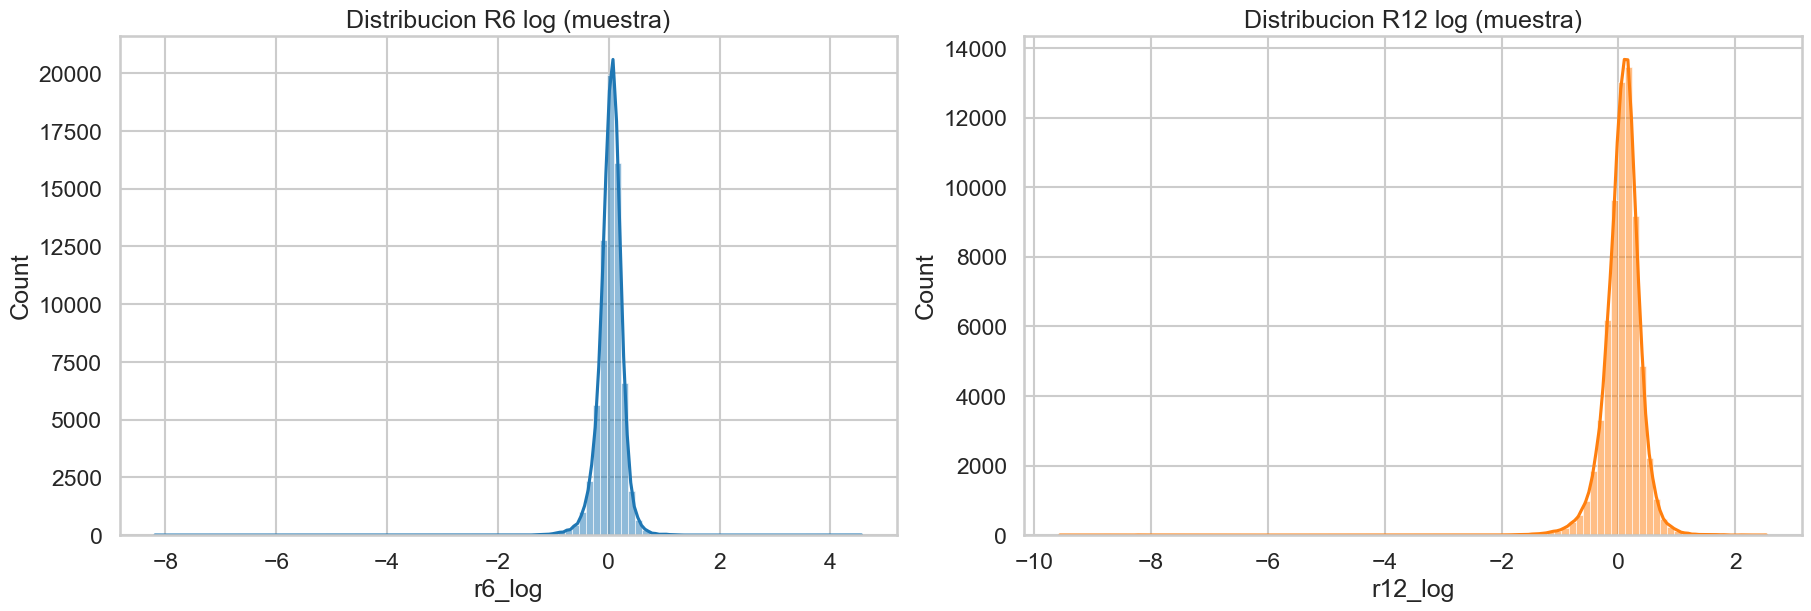

In [4]:
# Antes de usar logaritmos, validamos que todos los precios lag sean positivos.
positive_prices = (
    (signals_eligible["close_t1"] > 0)
    & (signals_eligible["close_t7"] > 0)
    & (signals_eligible["close_t13"] > 0)
)

invalid_price_rows = int((~positive_prices).sum())
record_check(
    n3_check_rows,
    "lag_prices_positive",
    invalid_price_rows == 0,
    f"invalid_price_rows={invalid_price_rows}",
)

# Retornos logaritmicos del enunciado, ambos con lag para evitar look-ahead.
signals_eligible["r12_log"] = np.log(
    signals_eligible["close_t1"] / signals_eligible["close_t13"]
)
signals_eligible["r6_log"] = np.log(
    signals_eligible["close_t1"] / signals_eligible["close_t7"]
)

# Comprobamos que no haya NaN/inf en retornos elegibles.
returns_finite_mask = np.isfinite(signals_eligible[["r12_log", "r6_log"]]).all(axis=1)
invalid_return_rows = int((~returns_finite_mask).sum())
record_check(
    n3_check_rows,
    "log_returns_finite",
    invalid_return_rows == 0,
    f"invalid_return_rows={invalid_return_rows}",
)

# Visual de control: distribucion de retornos (muestra para mantener ejecucion rapida).
returns_plot_df = signals_eligible[["r6_log", "r12_log"]].copy()
plot_sample_n = min(180000, len(returns_plot_df))
if plot_sample_n < len(returns_plot_df):
    returns_plot_df = returns_plot_df.sample(n=plot_sample_n, random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)

sns.histplot(returns_plot_df["r6_log"], bins=100, kde=True, ax=axes[0], color="#1f77b4")
axes[0].set_title("Distribucion R6 log (muestra)")
axes[0].set_xlabel("r6_log")

sns.histplot(returns_plot_df["r12_log"], bins=100, kde=True, ax=axes[1], color="#ff7f0e")
axes[1].set_title("Distribucion R12 log (muestra)")
axes[1].set_xlabel("r12_log")

print("Retornos logaritmicos calculados correctamente.")


## 5) Normalizacion cross-sectional (Z-score) y score compuesto

Por cada fecha de rebalanceo se estandarizan R6 y R12 con z-score.
Cuando la desviacion estandar de un factor en una fecha es cero, se asigna z-score = 0 para mantener estabilidad numerica.

Tambien se incluye una visualizacion para inspeccionar la relacion entre factores normalizados y la distribucion del score.


Z-scores y score compuesto calculados correctamente.


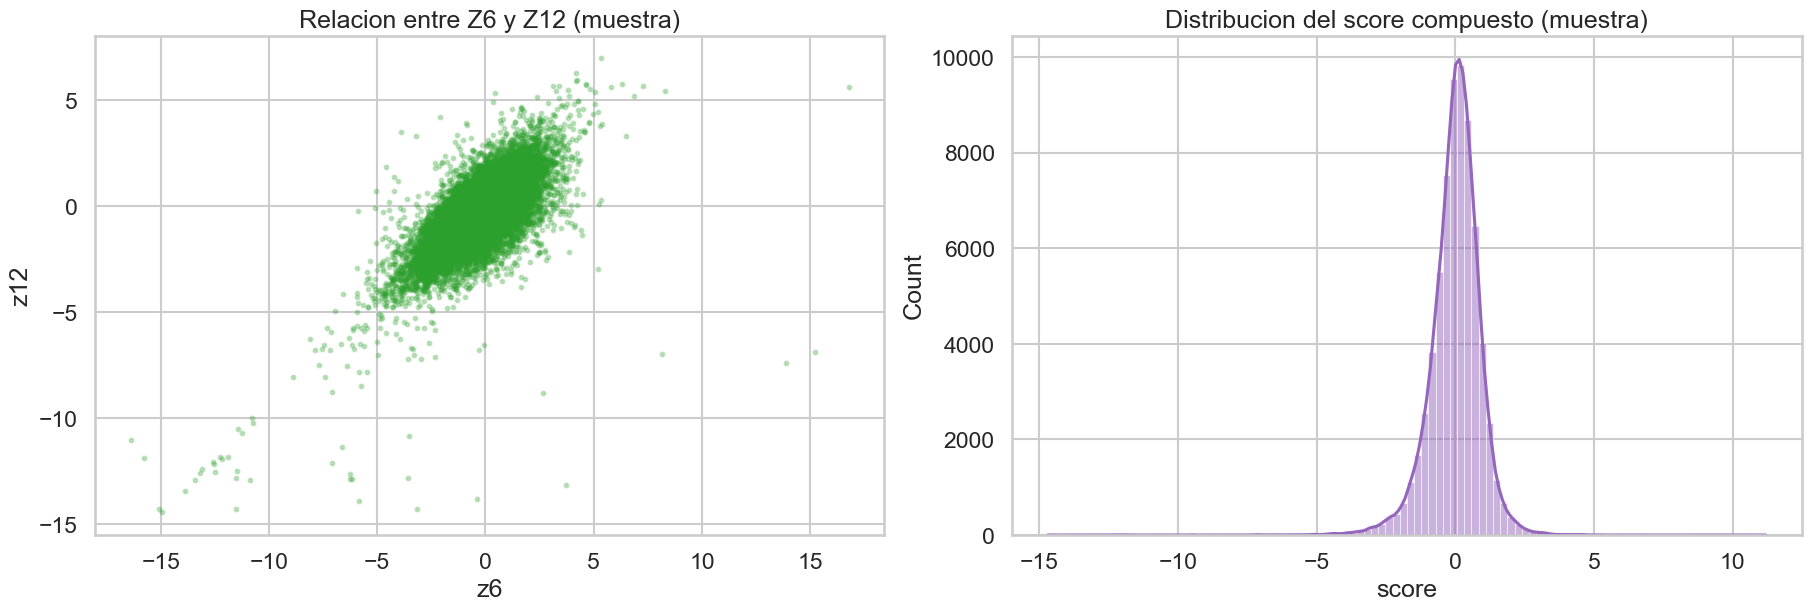

In [5]:
# Normalizacion cross-sectional por fecha: cada mes se compara contra su propio universo.
grouped = signals_eligible.groupby("rebalance_date", observed=True)

r12_mean = grouped["r12_log"].transform("mean")
r12_std = grouped["r12_log"].transform(lambda s: s.std(ddof=0))
r6_mean = grouped["r6_log"].transform("mean")
r6_std = grouped["r6_log"].transform(lambda s: s.std(ddof=0))

# Regla robusta: si std=0 en una fecha, el z-score de ese factor se fija en 0.
signals_eligible["z12"] = np.where(
    r12_std > 0,
    (signals_eligible["r12_log"] - r12_mean) / r12_std,
    0.0,
)
signals_eligible["z6"] = np.where(
    r6_std > 0,
    (signals_eligible["r6_log"] - r6_mean) / r6_std,
    0.0,
)

signals_eligible["score"] = (signals_eligible["z6"] + signals_eligible["z12"]) / 2.0

finite_scores_mask = np.isfinite(signals_eligible[["z12", "z6", "score"]]).all(axis=1)
invalid_score_rows = int((~finite_scores_mask).sum())
record_check(
    n3_check_rows,
    "zscore_and_score_finite",
    invalid_score_rows == 0,
    f"invalid_score_rows={invalid_score_rows}",
)

# Visual de control: relacion entre z6 y z12, y distribucion del score.
z_plot_df = signals_eligible[["z6", "z12", "score"]].copy()
z_sample_n = min(90000, len(z_plot_df))
if z_sample_n < len(z_plot_df):
    z_plot_df = z_plot_df.sample(n=z_sample_n, random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)
axes[0].scatter(z_plot_df["z6"], z_plot_df["z12"], s=8, alpha=0.25, color="#2ca02c")
axes[0].set_title("Relacion entre Z6 y Z12 (muestra)")
axes[0].set_xlabel("z6")
axes[0].set_ylabel("z12")

sns.histplot(z_plot_df["score"], bins=100, kde=True, ax=axes[1], color="#9467bd")
axes[1].set_title("Distribucion del score compuesto (muestra)")
axes[1].set_xlabel("score")

print("Z-scores y score compuesto calculados correctamente.")


## 6) Ranking determinista, top 20 por fecha y pesos objetivo

Se ordena por score descendente y, en empate, por simbolo ascendente.
Con ese orden se crea un ranking reproducible y se selecciona el top 20 por fecha.

La celda a?ade visualizacion de control para verificar que el corte top 20 se comporta de forma estable en el tiempo.


Seleccion top 20 construida correctamente.
Filas seleccionadas: 2660
Fechas seleccionadas: 133


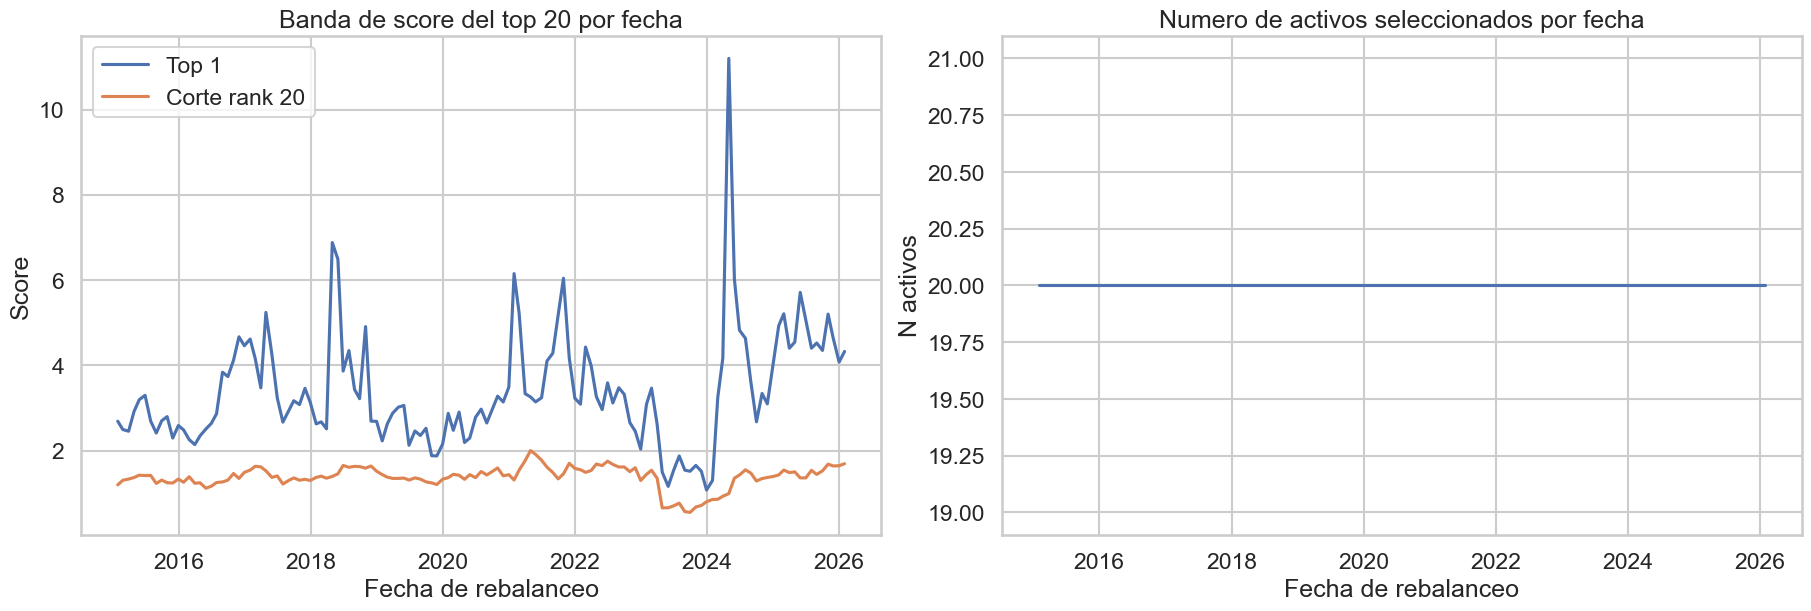

In [6]:
# Orden determinista: primero score y luego simbolo para desempates reproducibles.
ranked = signals_eligible.sort_values(
    ["rebalance_date", "score", "symbol"],
    ascending=[True, False, True],
).copy()

ranked["rank"] = ranked.groupby("rebalance_date", observed=True).cumcount() + 1
selected_top20 = ranked.loc[ranked["rank"] <= TOP_N_ASSETS].copy()
selected_top20["target_weight"] = TARGET_WEIGHT

selected_output = selected_top20[
    [
        "rebalance_date",
        "symbol",
        "rank",
        "r6_log",
        "r12_log",
        "z6",
        "z12",
        "score",
        "target_weight",
    ]
].sort_values(["rebalance_date", "rank", "symbol"]).reset_index(drop=True)

# Validaciones finales de calidad de salida.
selected_duplicates = int(
    selected_output.duplicated(["rebalance_date", "symbol"]).sum()
)
record_check(
    n3_check_rows,
    "selected_unique_key",
    selected_duplicates == 0,
    f"duplicate_rows={selected_duplicates}",
)

counts_per_date = selected_output.groupby("rebalance_date", observed=True)["symbol"].size()
invalid_count_dates = int((counts_per_date != TOP_N_ASSETS).sum())
record_check(
    n3_check_rows,
    "exactly_20_selected_per_date",
    invalid_count_dates == 0,
    f"failing_dates={invalid_count_dates}",
)

weights_per_date = selected_output.groupby("rebalance_date", observed=True)["target_weight"].sum()
invalid_weight_dates = int((~np.isclose(weights_per_date, 1.0)).sum())
record_check(
    n3_check_rows,
    "weights_sum_to_one_per_date",
    invalid_weight_dates == 0,
    f"failing_dates={invalid_weight_dates}",
)

rank_span = selected_output.groupby("rebalance_date", observed=True)["rank"].agg(["min", "max"])
invalid_rank_span = int(((rank_span["min"] != 1) | (rank_span["max"] != TOP_N_ASSETS)).sum())
record_check(
    n3_check_rows,
    "rank_span_is_1_to_20",
    invalid_rank_span == 0,
    f"failing_dates={invalid_rank_span}",
)

valid_dates_index = pd.Index(valid_rebalance_dates)
selected_dates = pd.Index(selected_output["rebalance_date"].drop_duplicates().sort_values())
missing_dates = int(len(valid_dates_index.difference(selected_dates)))
extra_dates = int(len(selected_dates.difference(valid_dates_index)))
record_check(
    n3_check_rows,
    "selected_dates_match_valid_calendar",
    (missing_dates == 0) and (extra_dates == 0),
    f"missing_dates={missing_dates} extra_dates={extra_dates}",
)

expected_rows = int(len(valid_dates_index) * TOP_N_ASSETS)
record_check(
    n3_check_rows,
    "selected_rows_expected",
    len(selected_output) == expected_rows,
    f"rows={len(selected_output)} expected_rows={expected_rows}",
)

# Visual de control: evolucion del score top-1 y score de corte (rank 20).
top1_score = (
    selected_output.loc[selected_output["rank"] == 1, ["rebalance_date", "score"]]
    .rename(columns={"score": "top1_score"})
)
cutoff_score = (
    selected_output.loc[
        selected_output["rank"] == TOP_N_ASSETS,
        ["rebalance_date", "score"],
    ]
    .rename(columns={"score": "top20_cutoff_score"})
)
score_band = top1_score.merge(cutoff_score, on="rebalance_date", how="inner")

fig, axes = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)

sns.lineplot(data=score_band, x="rebalance_date", y="top1_score", ax=axes[0], label="Top 1")
sns.lineplot(
    data=score_band,
    x="rebalance_date",
    y="top20_cutoff_score",
    ax=axes[0],
    label="Corte rank 20",
)
axes[0].set_title("Banda de score del top 20 por fecha")
axes[0].set_xlabel("Fecha de rebalanceo")
axes[0].set_ylabel("Score")

counts_plot_df = counts_per_date.rename("selected_count").reset_index()
sns.lineplot(data=counts_plot_df, x="rebalance_date", y="selected_count", ax=axes[1])
axes[1].set_title("Numero de activos seleccionados por fecha")
axes[1].set_xlabel("Fecha de rebalanceo")
axes[1].set_ylabel("N activos")

print("Seleccion top 20 construida correctamente.")
print("Filas seleccionadas:", len(selected_output))
print("Fechas seleccionadas:", len(selected_dates))


## 7) Exportes y readiness para Notebook 4

Se exporta el CSV obligatorio del enunciado y una tabla de checks de N3 para auditoria.
Si falla cualquier check critico o falta un artefacto, el notebook se detiene.

In [7]:
selected_output.to_csv(OUT_N3_SELECTED_CSV, index=False)

n3_checks_df = pd.DataFrame(n3_check_rows)
n3_checks_df.to_csv(OUT_N3_CHECKS_CSV, index=False)

artifacts_status = {
    "n3_selected_csv": pd.io.common.file_exists(OUT_N3_SELECTED_CSV),
    "n3_checks_csv": pd.io.common.file_exists(OUT_N3_CHECKS_CSV),
}

ready_for_n4 = {
    "all_critical_checks_passed": bool(
        n3_checks_df.loc[n3_checks_df["critical"], "passed"].all()
    ),
    "selected_csv_created": artifacts_status["n3_selected_csv"],
    "checks_csv_created": artifacts_status["n3_checks_csv"],
}

fail_if(
    not all(ready_for_n4.values()),
    "N3 readiness FAILED: revisar checks y exportes.",
)

print("N3 READINESS: PASS. El proyecto puede continuar en Notebook_4.")
print("\nChecklist N3:")
print(pd.DataFrame([ready_for_n4]).to_string(index=False))
print("\nEstado de artefactos N3:")
print(pd.DataFrame([artifacts_status]).to_string(index=False))
print("\nResumen de checks N3:")
print(n3_checks_df.to_string(index=False))
print("\nPreview seleccion final:")
print(selected_output.head(10).to_string(index=False))

N3 READINESS: PASS. El proyecto puede continuar en Notebook_4.

Checklist N3:
 all_critical_checks_passed  selected_csv_created  checks_csv_created
                       True                  True                True

Estado de artefactos N3:
 n3_selected_csv  n3_checks_csv
            True           True

Resumen de checks N3:
                              check  passed  critical                                          details
        n2_signals_required_columns    True      True                               missing_columns=[]
    signals_rebalance_date_not_null    True      True                       null_rebalance_date_rows=0
   calendar_rebalance_date_not_null    True      True                             null_calendar_rows=0
   calendar_has_required_lags_valid    True      True                    null_has_required_lags_rows=0
                 top_n_assets_is_20    True      True                                  top_n_assets=20
              target_weight_is_5pct    True      Tr

### Lectura rapida del bloque de checks

Los controles de N3 estan organizados por objetivo para facilitar la correccion y la auditoria del pipeline.
Los primeros checks validan integridad de inputs (esquema, fechas y flags de calendario).
Luego se validan la calidad estadistica de la se?al (precios positivos, retornos finitos, z-scores y score numericamente validos).
Despues se comprueba la consistencia de la seleccion top 20 (sin duplicados, 20 activos exactos por fecha, pesos que suman 1 y ranking 1-20).
Tambien se verifica la alineacion temporal con el calendario valido de rebalanceo y, por ultimo, la generacion de artefactos de salida para N4.

En esta tabla, `critical=True` significa que el check es bloqueante: si falla, se detiene el notebook.
`critical=False` (si apareciera en futuras versiones) significa control informativo: no bloquea ejecucion, pero deja evidencia tecnica para seguimiento.


## Fin Notebook 3

Este notebook deja lista la seleccion mensual top 20 para que `Notebook_4_Ejecucion_y_costes.ipynb`
aplique reglas de ejecucion (open/close) y estructura de costes del enunciado.